tensor(-0.1700, device='cuda:0') tensor(11.8050, device='cuda:0')


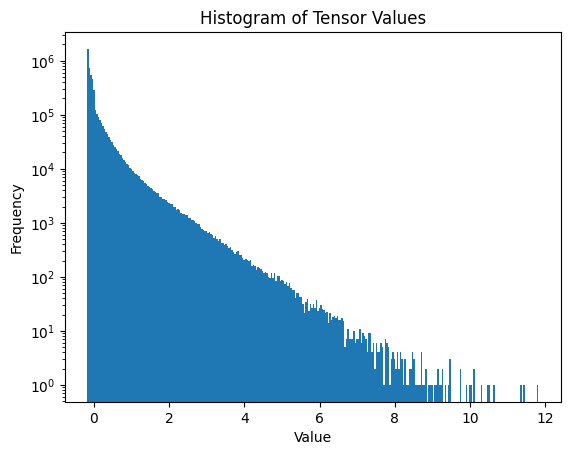

In [7]:
import torch

import matplotlib.pyplot as plt

# .pt 파일 불러오기
tensor = torch.load('x.pt')
print(tensor.min(), tensor.max())
# 텐서를 numpy 배열로 변환
tensor_np = tensor.cpu().numpy()
plt.hist(tensor_np.flatten(), bins=300)
plt.title('Histogram of Tensor Values')
plt.xlabel('Value')
plt.yscale('log')
plt.ylabel('Frequency')
plt.show()

In [4]:
def bitLog2Single( x):
    # 1. mask 0
    zeromask = x == 0
    # 2. get bit length - 1 (same as the bit length for representation)
    for i in torch.arange(0, 16):
        x = torch.where(x.bitwise_right_shift(i) == 1, i, x)
    # 3. -inf
    x[zeromask] = -99999
    x_q = x.clone().detach()
    # 4. dequantize
    x_dq = 2**x
    x_dq[zeromask] = 0

    return x_q, x_dq

def bitLog2Half(x):
    # 1. get log2(x)
    x_q, _ = bitLog2Single(x)

    def bitLog2Half_quant(x, x_q):
        # 2. get the mask for 1 (1 is 0.5)
        one_mask_half = x == 1
        # 3. get the half value
        x_temp = torch.where(
            x.bitwise_right_shift(x_q - 1).bitwise_and(1) == 1, 5, 0
        )
        # 4. 1 is 0.5
        x_temp[one_mask_half] = 5
        # 5. get the quantized value (int_part * 10 + frac_part)
        x_q_half = x_q * 10 + x_temp
        return x_q_half

    def bitLog2Half_dequant(x_q_half):
        # 1. get the mask for 0
        zero_mask = x_q_half == 0
        # 2. get the int part and frac part
        int_part = x_q_half // 10
        frac_part = x_q_half % 10 / 5
        _one = torch.ones_like(int_part)
        # 3. get the dequantized value
        int_num = _one.bitwise_left_shift(int_part)
        frac_num = frac_part * _one.bitwise_left_shift(int_part - 1)
        x_dq_half = int_num + frac_num
        x_dq_half[zero_mask] = 0

        return x_dq_half

    x_q_half = bitLog2Half_quant(x, x_q)
    x_dq_half = bitLog2Half_dequant(x_q_half)

    return x_q_half, x_dq_half

x = torch.arange(0, 32768)
print(x)
x_q, x_dq = bitLog2Single(x)
print(x_q)
x_q_half, x_dq_half = bitLog2Half(x)
print(x_q_half.unique())

tensor([    0,     1,     2,  ..., 32765, 32766, 32767])
tensor([-99999,      0,      1,  ...,     14,     14,     14])
tensor([-999990,       5,      10,      15,      20,      25,      30,      35,
             40,      45,      50,      55,      60,      65,      70,      75,
             80,      85,      90,      95,     100,     105,     110,     115,
            120,     125,     130,     135,     140,     145])


In [5]:
def bitLog2Quarter_quant(x, x_q):
    # 2. get the mask for 1 (1 is 0.5)
    one_mask_half = x == 1
    # 3. get the half value
    x_temp5 = torch.where(x.bitwise_right_shift(x_q - 1).bitwise_and(1) == 1, 1, 0)
    x_temp1 = torch.where(x.bitwise_right_shift(x_q - 2).bitwise_and(1) == 1, 1, 0)
    # 4. 1 is 0.5
    x_temp5[one_mask_half] = 1
    # 5. get the quantized value (int_part * 10 + frac_part)
    x_q_half = x_q * 100 + x_temp5*10 + x_temp1
    return x_q_half

def bitLog2Quarter_dequant(x_q_half):
    # 1. get the mask for 0
    zero_mask = x_q_half == 0
    # 2. get the int part and frac part
    int_part = x_q_half // 100
    frac_part5 = x_q_half % 100 // 10
    frac_part1 = x_q_half % 100 % 10 // 1     
    _one = torch.ones_like(int_part)
    # 3. get the dequantized value
    int_num = _one.bitwise_left_shift(int_part)
    frac_num5 = frac_part5 * _one.bitwise_left_shift(int_part - 1)
    frac_num1 = frac_part1 * _one.bitwise_left_shift(int_part - 2)
    x_dq_half = int_num + frac_num5 + frac_num1
    x_dq_half[zero_mask] = 0

    return x_dq_half

x = torch.arange(0, 32)
x_q, _ = bitLog2Single(x)
x_q_quarter = bitLog2Quarter_quant(x, x_q)
print(x_q_quarter.unique().numel(), x_q_quarter.unique())
x_dq_quarter = bitLog2Quarter_dequant(x_q_quarter)
print(x_dq_quarter.unique().numel(), x_dq_quarter.unique())

for dja, wns, tlr in zip(x, x_q_quarter, x_dq_quarter):
    print(dja, wns, tlr)

16 tensor([-9999900,       10,      100,      110,      200,      201,      210,
             211,      300,      301,      310,      311,      400,      401,
             410,      411])
16 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 14, 16, 20, 24, 28])
tensor(0) tensor(-9999900) tensor(0)
tensor(1) tensor(10) tensor(1)
tensor(2) tensor(100) tensor(2)
tensor(3) tensor(110) tensor(3)
tensor(4) tensor(200) tensor(4)
tensor(5) tensor(201) tensor(5)
tensor(6) tensor(210) tensor(6)
tensor(7) tensor(211) tensor(7)
tensor(8) tensor(300) tensor(8)
tensor(9) tensor(300) tensor(8)
tensor(10) tensor(301) tensor(10)
tensor(11) tensor(301) tensor(10)
tensor(12) tensor(310) tensor(12)
tensor(13) tensor(310) tensor(12)
tensor(14) tensor(311) tensor(14)
tensor(15) tensor(311) tensor(14)
tensor(16) tensor(400) tensor(16)
tensor(17) tensor(400) tensor(16)
tensor(18) tensor(400) tensor(16)
tensor(19) tensor(400) tensor(16)
tensor(20) tensor(401) tensor(20)
tensor(21) tensor(401) tensor(20)
tens

tensor(0) tensor(31)
tensor(2.4029e-06, device='cuda:0') tensor(1., device='cuda:0') 1054110
16 tensor([-9999900,       10,      100,      110,      200,      201,      210,
             211,      300,      301,      310,      311,      400,      401,
             410,      411], device='cuda:0')
16 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 14, 16, 20, 24, 28],
       device='cuda:0')
16 tensor([-0.1700,  0.2042,  0.5784,  0.9527,  1.3269,  1.7011,  2.0753,  2.4495,
         2.8237,  3.5722,  4.3206,  5.0691,  5.8175,  7.3144,  8.8112, 10.3081],
       device='cuda:0')


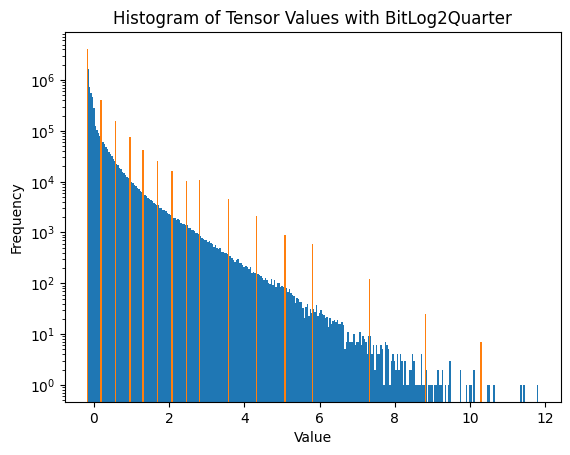

In [6]:
org_x = torch.load("x.pt")
print(x.min(), x.max())
x = org_x.clone()

x = x + 0.17
x_max = x.max()
x = (x / x_max)
print(x.min(), x.max(), x.unique().numel())

x = (x * 32).floor().int().clip(0, 31)
x_q, _ = bitLog2Single(x)
x_q_quarter = bitLog2Quarter_quant(x, x_q)
print(x_q_quarter.unique().numel(), x_q_quarter.unique())
x_dq_quarter = bitLog2Quarter_dequant(x_q_quarter)
print(x_dq_quarter.unique().numel(), x_dq_quarter.unique())
x_dq_quarter = x_dq_quarter / 32

x_dq_quarter = x_dq_quarter.float() * x_max

x_dq_quarter = x_dq_quarter - 0.17
print(x_dq_quarter.unique().numel(), x_dq_quarter.unique())
plt.hist(org_x.flatten().cpu().numpy(), bins=300)
plt.hist(x_dq_quarter.flatten().cpu().numpy(), bins=300)
plt.title("Histogram of Tensor Values with BitLog2Quarter")
plt.xlabel("Value")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()